# Import Necessary Libraries

In [13]:
import pandas as pd
import numpy as np
import  mlflow.sklearn
import matplotlib.pyplot as plt
import mlflow, argparse, joblib, warnings, itertools, pickle
# For Runtime Measurement
import time, timeit
# For Memory Usage
import psutil
warnings.filterwarnings('ignore')

# metrix,
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score, accuracy_score, f1_score

#Algorithms
from scipy.stats import randint
# from statsmodels.tsa.arima.model import ARIMAS
import statsmodels.api as sm
import xgboost as xgb

#Models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Loading Data

In [17]:
df = pd.read_parquet(r"../../data/2022/V6_ReduceDimension_Data.parquet")
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,taxi_demand
0,7232.423961,1.917840,3.593047,-1.520966,1.378757,1.594858,-0.398472,-0.214360,-2.450065,-0.298501,-2.372837,0.853763,-1.258673,-0.016103,-2.541717e-15,-4.228377e-14,1.265271e-17,9.903077e-21,-6.415206e-32,-0.086022
1,8450.424030,2.242227,3.789262,-0.164432,1.304658,0.776806,-0.565016,0.171054,-2.796305,-0.094508,-2.241521,1.258338,0.361904,0.040717,5.565055e-13,-2.290931e-16,-2.459113e-16,3.465575e-21,2.819584e-30,-0.086022
2,7568.423905,2.921402,3.676932,0.123669,1.305928,0.252489,-0.408997,0.327325,-2.931228,-0.347989,-2.125539,1.834953,0.778209,0.013537,-7.894685e-16,9.182485e-14,4.328383e-17,1.672041e-20,-5.235990e-31,-0.086022
3,9988.423917,4.125735,3.488578,0.979430,1.287473,-0.610574,-0.368645,0.694405,-3.199143,-0.312189,-1.877975,3.015216,1.453752,-0.073135,-2.309535e-15,1.066815e-13,-4.836991e-18,-1.045812e-19,-4.348663e-31,-0.086022
4,11093.423843,5.250869,3.348828,1.852266,1.265425,-1.525679,-0.294683,1.056983,-3.481290,-0.309485,-1.655867,4.082340,2.310911,-0.079123,1.132270e-15,1.138803e-14,4.044429e-17,-7.080540e-19,-2.756465e-30,-0.086022


In [18]:
df.shape

(8713, 20)

In [23]:
# splitig
X = df.drop(columns= ["taxi_demand",])
y = df.taxi_demand

In [24]:
y.isnull().sum()

0

In [20]:
# Load and preprocess your data (X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
X_train.shape, X_test.shape

((6970, 19), (1743, 19))

In [22]:
y_train.shape, y_test.shape

((6970,), (1743,))

# XGBoost

In [32]:
mlflow.set_experiment("XGBoostTuning")

with mlflow.start_run():
    x_model = xgb.XGBRFRegressor()

    param_dist = {
        'max_depth':  randint(1,16), #[3,4,5]
        'n_estimators': randint(100,600),
        'min_child_weight': randint(1,16), #[3, 4,5,6]
        'gamma': [0,0.1,0.2],
        'colsample_bytree':[0.7,0.8,0.9],
        'nthread': randint(1,16), #[3,4,5]
#         'reg_lambda': [0, 1, 10],
#         'objective': ['reg:squarederror', 'reg:squaredlogerror'],
        'eval_metric': ['rmse', 'mae'],
    }

    # run a randomized search
    n_iter_search = 20
    random_search = RandomizedSearchCV(x_model, param_distributions = param_dist, n_iter = n_iter_search,
                                       random_state=42)
    # fit the model
    random_search.fit(X_train, y_train)
    # Predict on the test set using the best estimator from the grid search
    y_pred = random_search.best_estimator_.predict(X_test)
    # Log parameters
    mlflow.log_params(random_search.best_params_)
    
    # Calculate and log the evaluation metric (e.g., RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(" ",end='\n')
    print(f"mean_squared_error: {rmse}")
    print(f"mean_absolute_percentage_error: {mape}")
    print(f"mean_absolute_error: {mae}")
    print(f"r2_score: {r2}")
    print(" ",end='\n')
    print(random_search.best_params_)
    print(" ",end='\n')

    #Log Matrics
    mlflow.log_metrics({
        "RMSE": rmse,
        "MAE": mae,
        "MAPE0": mape,
        "R2_SCORE": r2
    })
        
    # # Log the best model using MLflow
    mlflow.sklearn.log_model(x_model, 'XGBoost')

 
mean_squared_error: 0.3096306205540846
mean_absolute_percentage_error: 0.1436505680221113
mean_absolute_error: 0.02822608843267488
r2_score: 0.9122655829754972
 
{'colsample_bytree': 0.7, 'eval_metric': 'mae', 'gamma': 0, 'max_depth': 13, 'min_child_weight': 2, 'n_estimators': 466, 'nthread': 5}
 


# Visualization Testing

In [19]:
score = []

for i in range(1,16):
    x_model = xgb.XGBRFRegressor(gamma = i)
    x_model.fit(X_train, y_train)
    y_pred = x_model.predict(X_test)
    score.append(r2_score(y_test, y_pred))

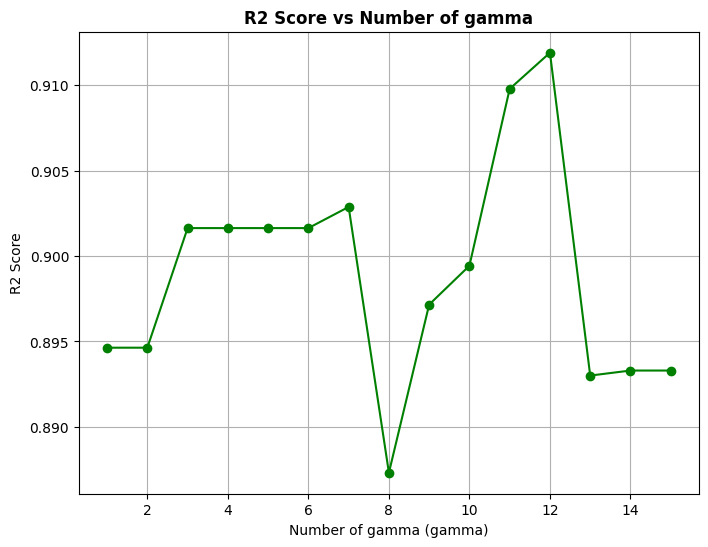

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 16), score, marker='o', color="green")  # Plotting n_neighbors vs R2 score
plt.title('R2 Score vs Number of gamma', weight="bold")
plt.xlabel('Number of gamma (gamma)')
plt.ylabel('R2 Score')
plt.grid(True)
plt.show()